In [1]:
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
# import sem
from scipy.stats import sem
import matplotlib as mpl
mpl.rcParams.update({
    # Keep text as editable text (not outlines)
    "pdf.fonttype": 42,      # embed TrueType in PDF (Illustrator-friendly)
    "ps.fonttype": 42,
    "svg.fonttype": "none",  # keep text as text in SVG
    # Use a common system font Illustrator will have
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    # Avoid mathtext converting to paths
    "text.usetex": False
})

In [2]:
# Function to compute rates and burst statistics
def compute_rates(spike_monitor, ca_monitor, duration, isi_threshold):
    """
    Computes firing rates and burst statistics.
    A burst is now defined as a sequence of spikes with ISI < isi_threshold,
    AND where a dendritic calcium spike (Ca_spike == 1) occurs during that sequence.
    """
    spike_trains = spike_monitor.spike_trains()
    # Get calcium spike data from the monitor
    ca_times = ca_monitor.t
    ca_values = ca_monitor.Ca_spike

    total_rates = []
    simple_rates = []
    burst_rates = []
    mean_burst_sizes = []
    mean_isis = []

    for i in range(spike_monitor.source.N):
        s_times = spike_trains[i]
        ca_trace = ca_values[i] # Get the calcium trace for this specific neuron
        total_spikes = len(s_times)

        if total_spikes == 0:
            total_rates.append(0.0)
            simple_rates.append(0.0)
            burst_rates.append(0.0)
            mean_burst_sizes.append(np.nan)
            mean_isis.append(np.nan)
            continue

        simple_count = 0
        burst_count = 0
        burst_sizes = []
        bursts_isis = []

        if total_spikes == 1:
            simple_count = 1
        else:
            current_burst_start_idx = 0
            in_burst = False
            # Iterate through ISIs
            for j in range(total_spikes - 1):
                isi = s_times[j+1] - s_times[j]
                if isi < isi_threshold:
                    if not in_burst:
                        # Start of a new potential burst
                        in_burst = True
                        current_burst_start_idx = j
                else: # isi >= isi_threshold, so potential burst ends (or it was a simple spike)
                    if in_burst:
                        # This is the end of a potential burst group. Now, we must check for a Ca spike.
                        burst_start_time = s_times[current_burst_start_idx]
                        burst_end_time = s_times[j]
                        # Find the time window in the calcium monitor
                        start_idx = np.searchsorted(ca_times, burst_start_time, side='left')
                        end_idx = np.searchsorted(ca_times, burst_end_time, side='right')

                        group_size = j - current_burst_start_idx + 1
                        # Check if Ca_spike was 1 at any point during this window
                        if np.any(ca_trace[start_idx:end_idx] == 1):
                            # It's a confirmed burst
                            burst_count += 1
                            burst_sizes.append(group_size)
                            burst_isis_vals = s_times[current_burst_start_idx+1:j+1] - s_times[current_burst_start_idx:j]
                            bursts_isis.append(list(burst_isis_vals / ms))
                        else:
                            # No Ca spike, so these are just fast simple spikes
                            simple_count += group_size
                        in_burst = False
                    else:
                        # This was a simple spike followed by a long ISI
                        simple_count += 1

            # After the loop, handle the last spike or the burst that continues to the end
            if in_burst:
                j = total_spikes - 1
                burst_start_time = s_times[current_burst_start_idx]
                burst_end_time = s_times[j]
                start_idx = np.searchsorted(ca_times, burst_start_time, side='left')
                end_idx = np.searchsorted(ca_times, burst_end_time, side='right')
                group_size = j - current_burst_start_idx + 1
                if np.any(ca_trace[start_idx:end_idx] == 1):
                    burst_count += 1
                    burst_sizes.append(group_size)
                    burst_isis_vals = s_times[current_burst_start_idx+1:j+1] - s_times[current_burst_start_idx:j]
                    bursts_isis.append(list(burst_isis_vals / ms))
                else:
                    simple_count += group_size
            else:
                # The very last spike was a simple spike
                simple_count += 1

        total_rate = total_spikes / (duration / second)
        simple_rate = simple_count / (duration / second)
        burst_rate = burst_count / (duration / second)
        mean_burst_size = np.mean(burst_sizes) if burst_sizes and np.mean(burst_sizes) > 2 else np.nan
        all_isis = [isi_val for sublist in bursts_isis for isi_val in sublist]
        mean_isi = np.mean(all_isis) if all_isis else np.nan

        total_rates.append(total_rate)
        simple_rates.append(simple_rate)
        burst_rates.append(burst_rate)
        mean_burst_sizes.append(mean_burst_size)
        mean_isis.append(mean_isi)

    return np.array(total_rates), np.array(simple_rates), np.array(burst_rates), np.array(mean_burst_sizes), np.array(mean_isis)


def FI_curve(N, I_s_ext, I_d_ext, sig_ou_s, sig_ou_d, mu_s, mu_d, rate_ampa_s=0, rate_gaba_s=0, rate_ampa_d=0, rate_gaba_d=0):
    if not isinstance(I_s_ext, (list, np.ndarray)):
        I_s_ext = [I_s_ext]
    I_s_ext = np.array(I_s_ext)
    
    simulation_time = 0.5  # seconds
    tau_stdp = 20 * ms
    isi_threshold = 14 * ms
    
    mean_total_rates = []
    mean_simple_rates = []
    mean_burst_rates = []
    mean_mean_burst_sizes = []
    mean_mean_isis = []
    std_total_rates = []
    std_simple_rates = []
    std_burst_rates = []
    std_mean_burst_sizes = []
    std_mean_isis = []
    mean_somatic_syn_currents = []
    std_somatic_syn_currents = []
    mean_dendritic_syn_currents = []
    std_dendritic_syn_currents = []
    mean_somatic_syn_conductances = []
    std_somatic_syn_conductances = []
    mean_dendritic_syn_conductances = []
    std_dendritic_syn_conductances = []

    for i_s in I_s_ext:
        start_scope()
        
        # Differential equations for the somatic compartment
        soma_eqs = '''
        du_s/dt = - (u_s - EL)/tau_s + (g_s * m + I_s + w_s) / C_s : volt (unless refractory)
        dw_s/dt = - w_s / tau_w_s : amp
        
        I_s = I_s_ext + I_ampa_s + I_gaba_s + I_s_bg : amp
        I_ampa_s = g_ampa_s * (V_ampa - u_s) : amp
        I_gaba_s = g_gaba_s * (V_gaba - u_s) : amp
        dI_s_bg/dt = (mu_s - I_s_bg) / tau_ou_s + sig_ou_s * xi_s/sqrt(tau_ou_s/2) : amp
        dg_ampa_s/dt = -g_ampa_s/tau_ampa : siemens
        dg_gaba_s/dt = -g_gaba_s/tau_gaba : siemens
        
        start_trace_burst : 1 (linked) 
        stop_trace_burst : 1 (linked) 
        u_d : volt (linked)
        m : 1 (linked)
        '''
    
        # Differential equations for the dendritic compartment
        dend_eqs = '''
        du_d/dt = - (u_d - EL)/tau_d + (g_d * m + K + I_d + w_d) / C_d : volt
        dw_d/dt = (- w_d + a_w_d * (u_d - EL)) / tau_w_d : amp
        
        I_d = I_d_ext + I_ampa_d + I_gaba_d + I_d_bg : amp
        I_ampa_d = g_ampa_d * (V_ampa - u_d) : amp
        I_gaba_d = g_gaba_d * (V_gaba - u_d) : amp
        dI_d_bg/dt = (mu_d - I_d_bg) / tau_ou_d + sig_ou_d * xi_d/sqrt(tau_ou_d/2) : amp
        dg_ampa_d/dt = -g_ampa_d/tau_ampa : siemens
        dg_gaba_d/dt = -g_gaba_d/tau_gaba : siemens
        
        dstart_trace_burst/dt = -start_trace_burst/tau_burst : 1
        dstop_trace_burst/dt = -stop_trace_burst/tau_burst : 1
    
        m = 1/(1 + exp(-(u_d - Ed) / Dm)) : 1
        Ca_spike = 1/(1 + exp(-(u_d - Ed2) / Dm2)) : 1
        
        lastspike_soma : second (linked)
        K_active = int((t-lastspike_soma) > K1) * int((t-lastspike_soma) < K2) : 1
        K = K_active * c_d : amp
        dburst_trace/dt = -burst_trace/tau_stdp : 1
        '''
    
        # Parameters for somatic compartment
        params_soma = {
            'tau_s': 16.0 * ms,
            'C_s': 370.0 * pF,
            'g_s': 1300.0 * pA,
            'b_w_s': -200 * pA,
            'tau_w_s': 100.0 * ms,
            'EL': -70 * mV,
            'Ed': -38 * mV,
            'Dm': 6 * mV,
            'mu_s': mu_s * pA,
            'tau_ou_s': 2.0 * ms,
            'tau_gaba': 10 * ms,
            'tau_ampa': 5 * ms,
            'I_s_ext': i_s * pA,
            'sig_ou_s': sig_ou_s * pA,
            'V_ampa': 0 * mV,
            'V_gaba': -80 * mV,
            'g_ampa_s_unit': 0.2* 1 * (370.0 * pF / (16.0 * ms)),
            'g_gaba_s_unit': 0.6* 1 * (370.0 * pF / (16.0 * ms)),
        }
        
        # Define somatic compartment
        soma = NeuronGroup(N, model=soma_eqs, threshold='u_s > -50 * mV',
                           reset='w_s += b_w_s\nu_s = EL\nstart_trace_burst += 1\nstop_trace_burst = 1',
                           refractory=3 * ms, namespace=params_soma, method='euler', dt=0.1 * ms)
    
        soma.u_s = 'EL + rand() * 10 * mV'
    
        # Parameters for dendritic compartment
        params_dend = {
            'tau_d': 7.0 * ms,
            'C_d': 170.0 * pF,
            'g_d': 1200.0 * pA,
            'c_d': 2600.0 * pA,
            'tau_w_d': 30.0 * ms,
            'a_w_d': -13 * nS,
            'EL': -70 * mV,
            'Ed': -38 * mV,
            'Dm': 6 * mV,
            'Ed2': -20 * mV,
            'Dm2': 0.01 * mV,
            'K1': 0.499 * ms,
            'K2': 2.501 * ms,
            'tau_burst': -16 / np.log(0.1) * ms,
            'mu_d': mu_d * pA,
            'tau_ou_d': 2.0 * ms,
            'tau_gaba': 10 * ms,
            'tau_ampa': 5 * ms,
            'I_d_ext': I_d_ext * pA,
            'sig_ou_d': sig_ou_d * pA,
            'tau_stdp': tau_stdp,
            'V_ampa': 0 * mV,
            'V_gaba': -80 * mV,
            'g_ampa_d_unit': 0.2  * 8 * (170.0 * pF / (7.0 * ms)),
            'g_gaba_d_unit': 0.4  * 8 * (170.0 * pF / (7.0 * ms)),
        }
    
        # Define dendritic compartment
        dend = NeuronGroup(N, model=dend_eqs, threshold='start_trace_burst > 1.1',
                           reset='burst_trace += 1\nstart_trace_burst = 0',
                           refractory='stop_trace_burst > 0.1', namespace=params_dend, method='euler', dt=0.1 * ms)
    
        dend.u_d = 'EL + rand() * 10 * mV'
    
        # Link variables between soma and dendrite
        soma.u_d = linked_var(dend, 'u_d')
        soma.m = linked_var(dend, 'm')
        dend.lastspike_soma = linked_var(soma, 'lastspike')
        soma.start_trace_burst = linked_var(dend, 'start_trace_burst')
        soma.stop_trace_burst = linked_var(dend, 'stop_trace_burst')
    
        # Poisson inputs for synaptic conductances
        poisson_ampa_s = PoissonGroup(N, rates=rate_ampa_s * Hz)
        poisson_gaba_s = PoissonGroup(N, rates=rate_gaba_s * Hz)
        poisson_ampa_d = PoissonGroup(N, rates=rate_ampa_d * Hz)
        poisson_gaba_d = PoissonGroup(N, rates=rate_gaba_d * Hz)
    
        # Synaptic connections
        syn_ampa_s = Synapses(poisson_ampa_s, soma, model='w : siemens', on_pre='g_ampa_s += w')
        syn_gaba_s = Synapses(poisson_gaba_s, soma, model='w : siemens', on_pre='g_gaba_s += w')
        syn_ampa_d = Synapses(poisson_ampa_d, dend, model='w : siemens', on_pre='g_ampa_d += w')
        syn_gaba_d = Synapses(poisson_gaba_d, dend, model='w : siemens', on_pre='g_gaba_d += w')
    
        syn_ampa_s.connect(j='i')
        syn_gaba_s.connect(j='i')
        syn_ampa_d.connect(j='i')
        syn_gaba_d.connect(j='i')
    
        syn_ampa_s.w = params_soma['g_ampa_s_unit']
        syn_gaba_s.w = params_soma['g_gaba_s_unit']
        syn_ampa_d.w = params_dend['g_ampa_d_unit']
        syn_gaba_d.w = params_dend['g_gaba_d_unit']

        vm_soma = StateMonitor(soma, 'u_s', record=True)
        vm_dend = StateMonitor(dend, 'u_d', record=True)

        # Monitor spikes from soma
        spike_soma = SpikeMonitor(soma)
        
        # Monitor the calcium spike variable from the dendrite
        ca_monitor = StateMonitor(dend, 'Ca_spike', record=True)
    
        # Monitors for currents
        current_soma = StateMonitor(soma, ['I_ampa_s', 'I_gaba_s'], record=True)
        current_dend = StateMonitor(dend, ['I_ampa_d', 'I_gaba_d'], record=True)


        g_soma = StateMonitor(soma, ['g_ampa_s', 'g_gaba_s'], record=True)
        g_dend = StateMonitor(dend, ['g_ampa_d', 'g_gaba_d'], record=True)

        # Run simulation
        run(simulation_time * second, report='stdout', profile=True)
        
        # Compute rates with the new calcium spike information
        total_rates, simple_rates, burst_rates, mean_burst_sizes, mean_isis = compute_rates(spike_soma, ca_monitor, simulation_time * second, isi_threshold)
        
        # Append means
        mean_total_rates.append(np.mean(total_rates))
        mean_simple_rates.append(np.mean(simple_rates))
        mean_burst_rates.append(np.mean(burst_rates))
        mean_mean_burst_sizes.append(np.nanmean(mean_burst_sizes))
        mean_mean_isis.append(np.nanmean(mean_isis))

        std_total_rates.append(np.std(total_rates) / np.sqrt(N))
        std_simple_rates.append(np.std(simple_rates) / np.sqrt(N))
        std_burst_rates.append(np.std(burst_rates) / np.sqrt(N))
        std_mean_burst_sizes.append(np.nanstd(mean_burst_sizes) / np.sqrt(N))
        std_mean_isis.append(np.nanstd(mean_isis) / np.sqrt(N))
        
        # Compute synaptic currents
        somatic_syn = (current_soma.I_ampa_s + current_soma.I_gaba_s) / pA  # (N, t)
        mean_somatic_per_neuron = np.mean(somatic_syn, axis=1)
        mean_somatic = np.mean(mean_somatic_per_neuron)
        std_somatic_per_neuron = np.std(somatic_syn, axis=1)
        mean_somatic_syn_currents.append(mean_somatic)
        std_somatic_syn_currents.append(np.mean(std_somatic_per_neuron))


        dendritic_syn = (current_dend.I_ampa_d + current_dend.I_gaba_d) / pA  # (N, t)
        mean_dendritic_per_neuron = np.mean(dendritic_syn, axis=1)
        mean_dendritic = np.mean(mean_dendritic_per_neuron)
        std_dendritic_per_neuron = np.std(dendritic_syn, axis=1)
        mean_dendritic_syn_currents.append(mean_dendritic)
        std_dendritic_syn_currents.append(np.mean(std_dendritic_per_neuron))

        # --- Compute synaptic conductances (in nS) ---
        # Somatic total conductance per neuron over time, then average across time, then across neurons
        somatic_g = (g_soma.g_ampa_s + g_soma.g_gaba_s) / nS  # shape (N, t)
        mean_somatic_g_per_neuron = np.mean(somatic_g, axis=1)     # (N,)
        mean_somatic_g = np.mean(mean_somatic_g_per_neuron)        # scalar
        std_somatic_g_per_neuron = np.std(somatic_g, axis=1)       # (N,)
        # Use SEM across neurons to match your rate SEM style
        mean_somatic_syn_conductances.append(mean_somatic_g)
        std_somatic_syn_conductances.append(np.mean(std_somatic_g_per_neuron))

        # Dendritic total conductance (in nS)
        dendritic_g = (g_dend.g_ampa_d + g_dend.g_gaba_d) / nS
        mean_dendritic_g_per_neuron = np.mean(dendritic_g, axis=1)
        mean_dendritic_g = np.mean(mean_dendritic_g_per_neuron)
        std_dendritic_g_per_neuron = np.std(dendritic_g, axis=1)
        mean_dendritic_syn_conductances.append(mean_dendritic_g)
        std_dendritic_syn_conductances.append(np.mean(std_dendritic_g_per_neuron))

    # Return results
    return {
        'I_s_ext': I_s_ext.tolist(),
        'mean_rates': mean_total_rates,
        'mean_simple_rates': mean_simple_rates,
        'mean_burst_rates': mean_burst_rates,
        'mean_burst_sizes': mean_mean_burst_sizes,
        'mean_isis': mean_mean_isis,
        'std_rates': std_total_rates,
        'std_simple_rates': std_simple_rates,
        'std_burst_rates': std_burst_rates,
        'std_burst_sizes': std_mean_burst_sizes,
        'std_isis': std_mean_isis,
        'mean_somatic_syn_currents': mean_somatic_syn_currents,
        'std_somatic_syn_currents': std_somatic_syn_currents,
        'mean_dendritic_syn_currents': mean_dendritic_syn_currents,
        'std_dendritic_syn_currents': std_dendritic_syn_currents,
        'mean_somatic_syn_conductances': mean_somatic_syn_conductances,
        'std_somatic_syn_conductances': std_somatic_syn_conductances,
        'mean_dendritic_syn_conductances': mean_dendritic_syn_conductances,
        'std_dendritic_syn_conductances': std_dendritic_syn_conductances
    }

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import numpy as np
import colorsys # Import the colorsys module


def generate_graded_colors(hex_color, n_colors=2):
    """
    Generates a list of graded colors from a base hex color to paler versions.
    """
    # Convert base hex to an RGB tuple (values 0-1)
    rgb_base = mcolors.to_rgb(hex_color)
    
    # Convert RGB to HLS (Hue, Lightness, Saturation)
    h, l, s = colorsys.rgb_to_hls(*rgb_base)
    
    # Create a list of lightness values, from original to a paler value (e.g., 0.8)
    lightness_steps = np.linspace(l, 0.7, n_colors)
    
    # Generate new RGB colors by adjusting lightness
    new_colors = []
    for new_l in lightness_steps:
        # Convert the new HLS color back to RGB
        new_colors.append(colorsys.hls_to_rgb(h, new_l, s))
    
    # add black to the start of new_colors
    new_colors.insert(0, (0, 0, 0))  # Adding black as the first color
        
    return new_colors

def plot_results(results1, results2, results3, figname, hexcolor):
    # --- Setup ---
    width = 25 / 25.4
    height = 55 / 25.4
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(width, height), sharex=True)

    # --- Data and Style Definitions ---
    results_list = [results1, results2, results3]
    styles = ['--', '-.', '-']
    
    # --- MODIFICATION START ---
    # Define color palettes for each axis
    # axes[0] uses the original grayscale
    colors_ax0 = generate_graded_colors(hexcolor)
    # axes[1] and axes[2] use the new function to generate graded colors
    colors_ax1 = generate_graded_colors(hexcolor)
    colors_ax2 = generate_graded_colors(hexcolor)
    # --- MODIFICATION END ---

    print(colors_ax0)

    # --- Plotting Loop ---
    # Iterate through each result set and its corresponding style
    for i, (res, style) in enumerate(zip(results_list, styles)):
        # --- MODIFICATION START ---
        # Plot each axis with its own graded color list
        axes[0].plot(res['I_s_ext'], res['mean_rates'], style, color=colors_ax0[i], linewidth=0.5)
        axes[1].plot(res['I_s_ext'], res['mean_simple_rates'], style, color=colors_ax1[i], linewidth=0.5)
        axes[2].plot(res['I_s_ext'], res['mean_burst_rates'], style, color=colors_ax2[i], linewidth=0.5)
        # --- MODIFICATION END ---

    # --- Axes Formatting ---


    axes[2].set_xticks([0, 1000])
    axes[2].set_xticklabels(['0', '1'])
    #axes[2].set_xlabel('I_s_ext (nA)')

    for ax in axes:
        plt.rcParams.update({'font.size': 5, 'font.family': 'sans-serif'})
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.25) 
        ax.spines['bottom'].set_linewidth(0.25) 
        ax.tick_params(direction='in', which='both', length=2, width=0.5, labelsize=5)

    # --- Custom Graded Triangle Colorbar (Unchanged) ---
    cax = fig.add_axes([0.8, 0.7, 0.1, 0.2])
    cmap = mcolors.LinearSegmentedColormap.from_list("grad", colors_ax0)
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient)).T
    img = cax.imshow(gradient, aspect='auto', cmap=cmap, origin='upper')
    triangle = Polygon([[0, 1], [1, 1], [0, 0]], transform=cax.transAxes)
    img.set_clip_path(triangle)
    
    cax.set_frame_on(False)
    cax.xaxis.set_visible(False)
    cax.set_yticks([])

    cax.tick_params(length=1, width=0.5)
    #cax.set_title(r'$\sigma_{input}$', fontsize=5, loc='center')


    for ax in axes:
        # all font size is set to 5
        plt.rcParams.update({'font.size': 5})
        # font set to sans-serif
        plt.rcParams.update({'font.family': 'sans-serif'})


        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.25) 
        ax.spines['bottom'].set_linewidth(0.25) 
        #axtemp.autoscale(enable=True, axis='both')
        ax.tick_params(direction='in', which='both', length=0.5, width=0.5,labelsize=5)

    axes[0].legend(['','',''], loc='upper left',    
                    bbox_to_anchor=(0, 1), 
                    borderaxespad=0,
                    labelspacing=0.2, 
                    fontsize=5, 
                    frameon=False, 
                    handlelength=1
    )   

    axes[0].set_ylim([0, 60])
    axes[1].set_ylim([0, 20])
    axes[2].set_ylim([0, 10])

    # --- Final Touches ---
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    
    plt.show()

    fig.savefig(figname, bbox_inches='tight', dpi=300)


def plot_results_syncurrent(results1, results2, results3, figname, hexcolor):
    # --- Setup ---
    width = 25 / 25.4
    height = 50 / 25.4
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(width, height), sharex=True)

    # --- Data and Style Definitions ---
    results_list = [results1, results2, results3]
    styles = ['--', '-.', '-']
    
    # --- MODIFICATION START ---
    # Define color palettes for each axis
    # axes[0] uses the original grayscale
    colors_ax0 = generate_graded_colors(hexcolor)
    # axes[1] and axes[2] use the new function to generate graded colors
    colors_ax1 = generate_graded_colors(hexcolor)
    colors_ax2 = generate_graded_colors(hexcolor)
    # --- MODIFICATION END ---

    print(colors_ax0)

    # --- Plotting Loop ---
    # Iterate through each result set and its corresponding style
    # for i, (res, style) in enumerate(zip(results_list, styles)):
    #     axes[0].plot(res['I_s_ext'], res['std_somatic_syn_currents'], style, color=colors_ax2[i], linewidth=0.5)
    #     axes[1].plot(res['I_s_ext'], res['std_dendritic_syn_currents'], style, color=colors_ax2[i], linewidth=0.5)
        # --- MODIFICATION END ---


    # --- Axes Formatting ---
    # axes[0].set_ylim([0, 60])
    # axes[1].set_ylim([0, 20])
    # axes[2].set_ylim([0, 10])

    axes[1].set_xticks([0, 1000])
    axes[1].set_xticklabels(['0', '1'])
    #axes[2].set_xlabel('I_s_ext (nA)')

    for ax in axes:
        plt.rcParams.update({'font.size': 5, 'font.family': 'sans-serif'})
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.25) 
        ax.spines['bottom'].set_linewidth(0.25) 
        ax.tick_params(direction='in', which='both', length=2, width=0.5, labelsize=5)

    # --- Custom Graded Triangle Colorbar (Unchanged) ---
    cax = fig.add_axes([0.8, 0.7, 0.1, 0.2])
    cmap = mcolors.LinearSegmentedColormap.from_list("grad", colors_ax0)
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient)).T
    img = cax.imshow(gradient, aspect='auto', cmap=cmap, origin='upper')
    triangle = Polygon([[0, 1], [1, 1], [0, 0]], transform=cax.transAxes)
    img.set_clip_path(triangle)
    
    cax.set_frame_on(False)
    cax.xaxis.set_visible(False)
    cax.set_yticks([])

    cax.tick_params(length=1, width=0.5)
    #cax.set_title(r'$\sigma_{input}$', fontsize=5, loc='center')


    for ax in axes:
        # all font size is set to 5
        plt.rcParams.update({'font.size': 5})
        # font set to sans-serif
        plt.rcParams.update({'font.family': 'sans-serif'})


        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.25) 
        ax.spines['bottom'].set_linewidth(0.25) 
        #axtemp.autoscale(enable=True, axis='both')
        ax.tick_params(direction='in', which='both', length=0.5, width=0.5,labelsize=5)

    # axes[0].legend(['','',''], loc='upper left',    
    #                 bbox_to_anchor=(0, 1), 
    #                 borderaxespad=0,
    #                 labelspacing=0.2, 
    #                 fontsize=5, 
    #                 frameon=False, 
    #                 handlelength=1
    # )   


    # --- Final Touches ---
    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    
    plt.show()

    fig.savefig(figname, bbox_inches='tight', dpi=300)


In [4]:
def plot_bg_input(results1, results2, results3, figname):
    width = 12 / 25.4
    height = 20 / 25.4
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width, height), sharex=True)

    t1 = 200
    t2 = 300

    ax.plot(results1['t'][t1:t2] / ms, results1['I_s_bg'][0][t1:t2] / pA, lw=0.5)
    ax.plot(results2['t'][t1:t2] / ms, results2['I_s_bg'][0][t1:t2] / pA, lw=0.5)
    ax.plot(results3['t'][t1:t2] / ms, results3['I_s_bg'][0][t1:t2] / pA, lw=0.5)

    #ax.set_xlim(200, 210)

    #ax.axis('off')
    # adjust y lim auto


    plt.show()
    fig.savefig(figname, bbox_inches='tight', dpi=300)



In [5]:
N_neuron = 5000

rate_s1 = 100
rate_s2 = 200
rate_s3 = 300

rate_d1 = 0
rate_d2 = 0
rate_d3 = 0

results1 = FI_curve(N=N_neuron, I_s_ext=np.linspace(0, 1000, 11), I_d_ext=0, sig_ou_s=0, sig_ou_d=0, mu_s=0, mu_d=0, rate_ampa_s=rate_s1, rate_gaba_s=rate_s1, rate_ampa_d=rate_d1, rate_gaba_d=rate_d1)
results2 = FI_curve(N=N_neuron, I_s_ext=np.linspace(0, 1000, 11), I_d_ext=0, sig_ou_s=0, sig_ou_d=0, mu_s=0, mu_d=0, rate_ampa_s=rate_s2, rate_gaba_s=rate_s2, rate_ampa_d=rate_d2, rate_gaba_d=rate_d2)
results3 = FI_curve(N=N_neuron, I_s_ext=np.linspace(0, 1000, 11), I_d_ext=0, sig_ou_s=0, sig_ou_d=0, mu_s=0, mu_d=0, rate_ampa_s=rate_s3, rate_gaba_s=rate_s3, rate_ampa_d=rate_d3, rate_gaba_d=rate_d3)

WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0. * amp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "mu_s" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0. * amp, but the name also refers to a variable in the run namespace with value '0'. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    The name "sig_ou_s" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0. * am

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 7s


WARNING    /var/folders/8g/cpkd0cfs4gn915zwbfdfgf9w0000gn/T/ipykernel_80740/4089793155.py:304: RuntimeWarning: Mean of empty slice
  mean_mean_burst_sizes.append(np.nanmean(mean_burst_sizes))
 [py.warnings]
WARNING    /var/folders/8g/cpkd0cfs4gn915zwbfdfgf9w0000gn/T/ipykernel_80740/4089793155.py:305: RuntimeWarning: Mean of empty slice
  mean_mean_isis.append(np.nanmean(mean_isis))
 [py.warnings]
WARNING    /Users/qixinyang/opt/anaconda3/envs/brian2_env/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 [py.warnings]
WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 100. * pamp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900.

Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 200. * pamp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 300. * pamp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0.4 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 0.5 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0.6 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 0.7 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0.8 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 0.9 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 1. * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 0. * amp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 100. * pamp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 200. * pamp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 300. * pamp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 0.4 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0.5 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 0.6 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0.7 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 0.8 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup". Will use the object from the group-specific namespace with the value 0.9 * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    The name "I_s_ext" refers to different objects in different namespaces used for resolving names in the context of group "neurongroup_2". Will use the object from the group-specific namespace with the value 1. * namp, but the name also refers to a variable in the run namespace with value 'array([   0.,  100.,  200., ...,  800.,  900., 1000.], shape=(11,))'. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s
Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


WARNING    /var/folders/8g/cpkd0cfs4gn915zwbfdfgf9w0000gn/T/ipykernel_80740/3041554517.py:240: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]


[(0, 0, 0), (np.float64(0.23137254901960785), np.float64(0.33333333333333337), np.float64(0.41568627450980394)), (np.float64(0.6145454545454544), np.float64(0.7090909090909091), np.float64(0.7854545454545455))]


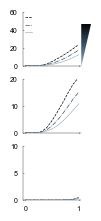

In [6]:
plot_results(results1, results2, results3, 'synaptic_input_FI_nodend.pdf','#3B556A')